In [1]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 43.9 MB/s 
     |████████████████████████████████| 596 kB 38.2 MB/s 
     |████████████████████████████████| 101 kB 11.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
# Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers

import transformers

# Visualization
from matplotlib import pyplot as plt

# Text processing
import re
import nltk
import gensim.downloader as api

# Various
from datetime import datetime

In [3]:
# Select the dataset for the analysis
df = pd.read_csv("final_3label11.csv")
df = df[["sentence", "label"]]

# Show the data
df.head()

,sentence,label
0,usage and adverse effects of identified mtbfad...,1
1,long-term maternal administration of ritodrine...,1
2,/2021 assessed for eligibility (n=102) exclude...,1
3,35 this is an important consideration when com...,1
4,"thus, hospital admission in itself is a severe...",1


In [4]:
print('Total number of news: {}'.format(len(df)))
print(40*'-')
print('Split by category:')
print(df["label"].value_counts())
print(40*'-')
nr_categories = len(df["label"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number of news: 828
----------------------------------------
Split by category:
2    528
1    300
Name: label, dtype: int64
----------------------------------------
Number of categories: 2


In [5]:
# You can adjust n:
n=100
print('Category: ',df['label'][n])
print(100*'-')
print('Text:')
print(df['sentence'][n])

Category:  1
----------------------------------------------------------------------------------------------------
Text:
although naltrexone/bupropion may increase blood pressure and should therefore not be used in patients with uncontrolled hypertension, no adverse signal for increased cardiovascular events was found in the interim analysis of a cardiovascular outcome trial 75 .in 2014, liraglutide 3 mg became the first glp1-based aom to be introduced to the us market for treatment of obesity in adults, and in 2020 was approved for weight management in adolescents aged 12 years and older with obesity (see related links).


In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [7]:
# Reference: Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT from Medium

# Use stopwords list from nltk
lst_stopwords = nltk.corpus.stopwords.words("english")

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # Clean (convert to lowercase and remove punctuations and characters and then strip)
    # The function is not optimized for speed but split into various steps for pedagogical purpose
    text = str(text).lower()
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize (convert from string to list)
    lst_text = text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    # back to string from list
    text = " ".join(lst_text)
    return text
# Let's apply this function to the whole corpus
df["sentence_clean"] = df["sentence"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

# Let's look at the output
df.head()

,sentence,label,sentence_clean
0,usage and adverse effects of identified mtbfad...,1,usage adverse effect identified mtbfadd32 pote...
1,long-term maternal administration of ritodrine...,1,longterm maternal administration ritodrine kno...
2,/2021 assessed for eligibility (n=102) exclude...,1,2021 assessed eligibility n102 excluded n5 scr...
3,35 this is an important consideration when com...,1,35 important consideration comparing outcome r...
4,"thus, hospital admission in itself is a severe...",1,thus hospital admission severe prognostic fact...


In [8]:
X = df['sentence_clean']
y = df['label']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df['label'])

In [10]:
corpus = X_train
#Initizalize the vectorizer with max nr words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus)
TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

In [11]:
classifier_tfidf = LogisticRegression()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

In [12]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))
predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

Accuracy Training data: 96.2%
Accuracy Test data: 88.0%
Training time: 0.3s


NameError: ignored

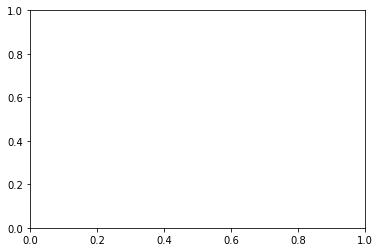

In [13]:
ax= plt.subplot()
conf_matrix = pd.DataFrame(matrix)
conf_matrix=sns.heatmap(matrix, annot=True, fmt='g', ax=ax);
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
ax.set_title('Confusion Matrix Logistic Regreesion TFIDF'); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_test_tfidf))


In [ ]:
clf_report_nn = classification_report(y_test, predicted_test_tfidf, labels=[1, 2 ], target_names=['Negative', 'Positive'], output_dict=True)
sns.heatmap(pd.DataFrame(clf_report_nn).iloc[:-1, :].T, annot=True)
ax.set_title('Classification Report Neural Network'); 